# Install Necessary Package

In [ ]:
!pip install tensorflow-addons
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 1.1 MB 2.8 MB/s 
     |████████████████████████████████| 58 kB 2.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=f7ff5f3923a92c3382e7947eb8ff6ab0113c3a5323a08145365c883d7c24c0a4
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


# Download dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dog-breed-identification

100% 689M/691M [00:12<00:00, 60.6MB/s]
100% 691M/691M [00:12<00:00, 57.2MB/s]


# Data preparation

In [ ]:
import zipfile
import pandas as pd
import os

import tensorflow as tf
from sklearn import preprocessing

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
np.__version__

'1.19.5'

In [ ]:
dataset_url = "dog-breed-identification.zip"
with zipfile.ZipFile(dataset_url, 'r') as zip_ref:
   zip_ref.extractall("dogbreed")

In [ ]:
BASE_DIR = "dogbreed/"
df = pd.read_csv(BASE_DIR + "labels.csv")

le = preprocessing.LabelEncoder()
le.fit(df['breed'])

breed_to_code = dict(zip(le.classes_, le.transform(le.classes_)))
code_to_breed = dict(zip(le.transform(le.classes_), le.classes_ ))

df['label'] = df['breed'].map(breed_to_code)
df['path'] = df['id'].map(lambda x: os.path.join(BASE_DIR, "train", x+".jpg"))

df.head()

,id,breed,label,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,dogbreed/train/000bec180eb18c7604dcecc8fe0dba0...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba9...
2,001cdf01b096e06d78e9e5112d419397,pekinese,85,dogbreed/train/001cdf01b096e06d78e9e5112d41939...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15,dogbreed/train/00214f311d5d2247d5dfe4fe24b2303...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49,dogbreed/train/0021f9ceb3235effd7fcde7f7538ed6...


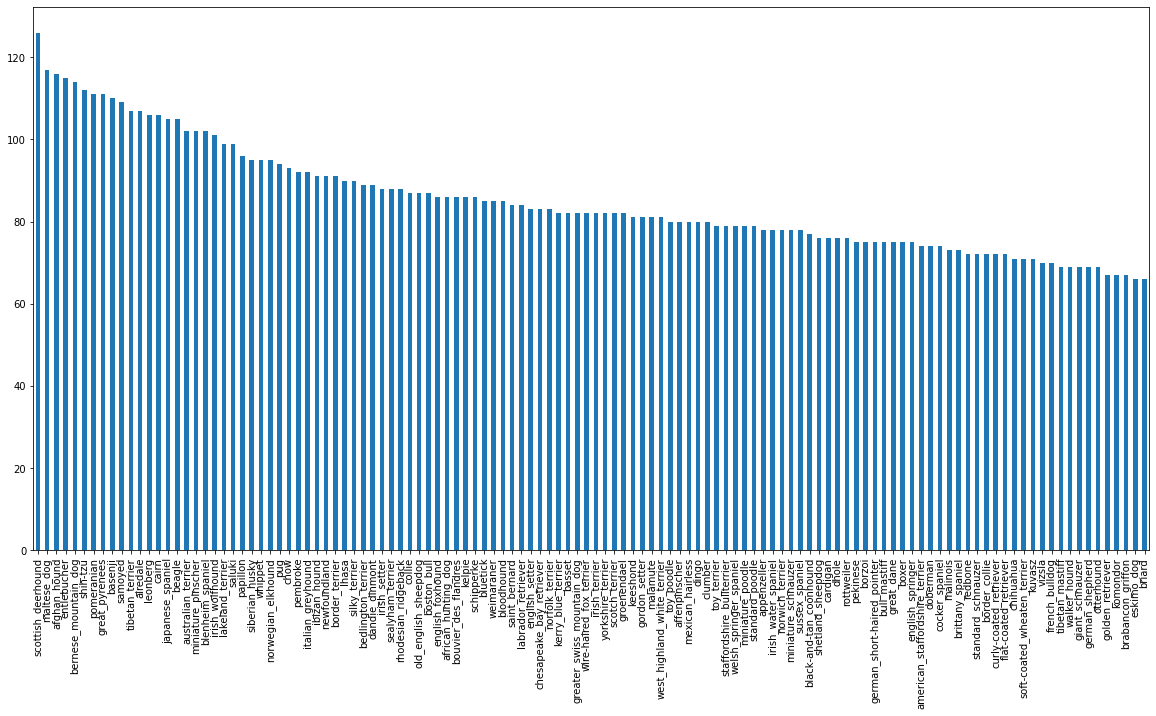

In [ ]:
plt.figure(figsize=(20,10))
df['breed'].value_counts().plot.bar()

In [ ]:
img_height, img_width = 331,331
BS = 8


In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_data(file_path, label):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
list_ds = tf.data.Dataset.from_tensor_slices((df.path, df.label))
list_ds_shuffle = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)

In [ ]:
val_size = int(len(list_ds) * 0.1)
train_ds = list_ds_shuffle.skip(val_size)
val_ds = list_ds_shuffle.take(val_size)

train_ds = train_ds.map(lambda x, y: process_data(x, y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: process_data(x,y), num_parallel_calls=tf.data.AUTOTUNE)

print(f"No of training data = {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"No of validation data = {tf.data.experimental.cardinality(val_ds).numpy()}")

No of training data = 9200
No of validation data = 1022


In [ ]:
def configure_for_performance(ds, shuffle=False):
  ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BS)
  # ds = ds.map(lambda x, y: (preprocess_input_inception(x), y),
	# 	        num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds, shuffle=True)
val_ds = configure_for_performance(val_ds)

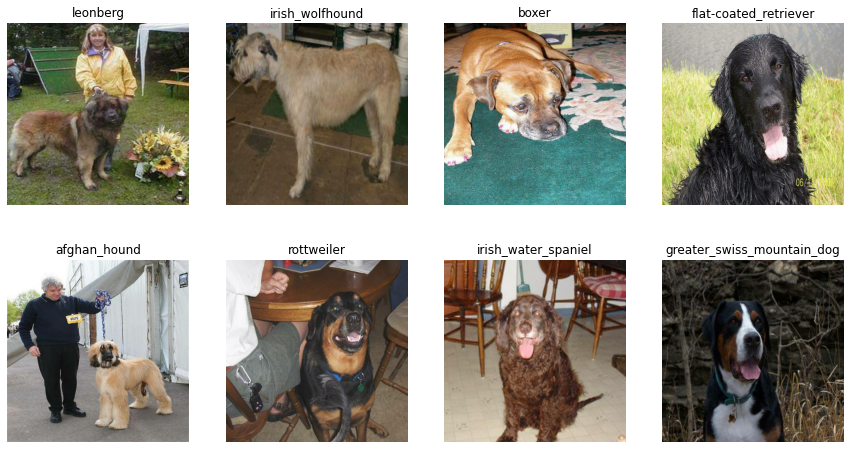

In [ ]:
plt.figure(figsize=(15,8))
for img, lbl in val_ds.take(1):
  for i in range(8):
    plt.subplot(2,4, i+1)
    plt.imshow(img[i].numpy().astype('uint8'))
    plt.title(code_to_breed[lbl[i].numpy()])
    plt.axis('off')
plt.show()

# Function Helper

In [ ]:
from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [ ]:
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

# Model

In [ ]:
IMG_SHAPE = (img_height, img_width) + (3,)

In [ ]:
def build_model(baseModel, augmentation, preprocess_fn, input_shape):
  inputs = tf.keras.Input(shape=input_shape)
  x = augmentation(inputs)
  x = preprocess_fn(x)
  x = baseModel(x, training=False)
  avg = tf.keras.layers.GlobalAveragePooling2D()(x)
  mx = tf.keras.layers.GlobalMaxPool2D()(x)

  x = tf.keras.layers.Concatenate()([avg, mx])
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  outputs  = tf.keras.layers.Dense(120, activation='softmax')(x)
  newModel = tf.keras.Model(inputs, outputs)

  return newModel

In [ ]:
# resnet50 = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# pre_resnet50 = tf.keras.applications.resnet_v2.preprocess_input

preprocess_input_inception = tf.keras.applications.nasnet.preprocess_input
inception = tf.keras.applications.nasnet.NASNetLarge(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
inception.trainable = False

343621632/343610240 [==============================] - 21s 0us/step


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
])

In [ ]:
## Find learning rate
lr_finder = LRFinder(start_lr=1e-8, end_lr=1)

model = build_model(inception, data_augmentation, preprocess_input_inception, IMG_SHAPE)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy')
_ = model.fit(train_ds, epochs=5, callbacks=[lr_finder], verbose=True)

lr_finder.plot()

Epoch 1/5
 793/1150 [===================>..........] - ETA: 3:34 - loss: 4.1749

In [ ]:
epochs = 10
lr = 1e-2
# steps = np.ceil(len(x_train) / batch_size) * epochs
steps = len(train_ds) * epochs
lr_schedule = OneCycleScheduler(lr, steps)

model = build_model(inception, data_augmentation, preprocess_input_inception, IMG_SHAPE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,  callbacks=[lr_schedule], verbose=True)

Epoch 1/10
575/575 [==============================] - 75s 120ms/step - loss: 2.0477 - accuracy: 0.5098 - val_loss: 3.1671 - val_accuracy: 0.4403
Epoch 2/10
575/575 [==============================] - 68s 117ms/step - loss: 2.0587 - accuracy: 0.5010 - val_loss: 3.3746 - val_accuracy: 0.5254
Epoch 3/10
575/575 [==============================] - 68s 117ms/step - loss: 1.6370 - accuracy: 0.5640 - val_loss: 1.0924 - val_accuracy: 0.7016
Epoch 4/10
575/575 [==============================] - 67s 117ms/step - loss: 1.4504 - accuracy: 0.6052 - val_loss: 1.3998 - val_accuracy: 0.6399
Epoch 5/10
575/575 [==============================] - 67s 117ms/step - loss: 1.3453 - accuracy: 0.6296 - val_loss: 0.9412 - val_accuracy: 0.7436
Epoch 6/10
575/575 [==============================] - 67s 117ms/step - loss: 1.2304 - accuracy: 0.6520 - val_loss: 1.1075 - val_accuracy: 0.7446
Epoch 7/10
575/575 [==============================] - 68s 118ms/step - loss: 1.1324 - accuracy: 0.6755 - val_loss: 1.0099 - val_ac

In [ ]:
epochs = 10
lr = 1e-3
steps = len(train_ds) * epochs
lr_schedule = OneCycleScheduler(lr, steps)

model.optimizer.learning_rate = lr

history2 = model.fit(train_ds, validation_data=val_ds, epochs=epochs,  callbacks=[lr_schedule], verbose=True)

Epoch 1/10
575/575 [==============================] - 67s 117ms/step - loss: 0.8774 - accuracy: 0.7373 - val_loss: 1.0314 - val_accuracy: 0.7926
Epoch 2/10
575/575 [==============================] - 67s 117ms/step - loss: 0.8826 - accuracy: 0.7365 - val_loss: 0.7812 - val_accuracy: 0.7975
Epoch 3/10
575/575 [==============================] - 67s 117ms/step - loss: 0.8865 - accuracy: 0.7342 - val_loss: 0.8078 - val_accuracy: 0.7926
Epoch 4/10
575/575 [==============================] - 67s 117ms/step - loss: 0.8804 - accuracy: 0.7364 - val_loss: 0.8527 - val_accuracy: 0.7886
Epoch 5/10
575/575 [==============================] - 67s 117ms/step - loss: 0.8658 - accuracy: 0.7382 - val_loss: 0.9135 - val_accuracy: 0.7867
Epoch 6/10
575/575 [==============================] - 67s 117ms/step - loss: 0.8537 - accuracy: 0.7457 - val_loss: 0.7033 - val_accuracy: 0.8004
Epoch 7/10
575/575 [==============================] - 67s 117ms/step - loss: 0.8155 - accuracy: 0.7548 - val_loss: 0.7853 - val_ac

In [ ]:
model.optimizer.learning_rate = 8e-4
history2 = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=True)

Epoch 1/10
544/544 [==============================] - 65s 120ms/step - loss: 0.9664 - accuracy: 0.7216 - val_loss: 1.0704 - val_accuracy: 0.8017
Epoch 2/10
544/544 [==============================] - 65s 120ms/step - loss: 0.9387 - accuracy: 0.7259 - val_loss: 1.1766 - val_accuracy: 0.8082
Epoch 3/10
544/544 [==============================] - 65s 120ms/step - loss: 0.9535 - accuracy: 0.7225 - val_loss: 0.6669 - val_accuracy: 0.8043
Epoch 4/10
544/544 [==============================] - 65s 120ms/step - loss: 0.9615 - accuracy: 0.7272 - val_loss: 0.9340 - val_accuracy: 0.8023
Epoch 5/10
544/544 [==============================] - 65s 120ms/step - loss: 0.9612 - accuracy: 0.7216 - val_loss: 0.6779 - val_accuracy: 0.8050
Epoch 6/10
544/544 [==============================] - 65s 120ms/step - loss: 0.9577 - accuracy: 0.7244 - val_loss: 0.8478 - val_accuracy: 0.8063
Epoch 7/10
544/544 [==============================] - 65s 120ms/step - loss: 0.9738 - accuracy: 0.7241 - val_loss: 0.6599 - val_ac

In [ ]:
model.save('my_model_8080.h5')

In [ ]:
from google.colab import files
files.download('my_model_8030.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test with real images

In [ ]:
nurl = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/ChowChow2Szczecin.jpg/1200px-ChowChow2Szczecin.jpg"

In [ ]:
from PIL import Image
import requests
from io import BytesIO

(-0.5, 1199.5, 899.5, -0.5)

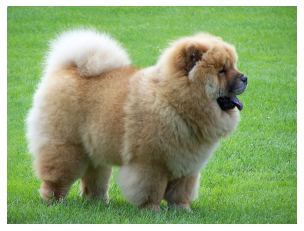

In [ ]:
response = requests.get(nurl)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.axis('off')


In [ ]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_reisze = tf.image.resize(img_array, [img_height, img_width])
img_array = tf.expand_dims(img_reisze, 0) # Create a batch

score = model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(code_to_breed[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to chow with a 99.54 percent confidence.
